In [51]:
from itertools import pairwise, accumulate

import polars as pl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.signal import savgol_filter

In [52]:
r = 6378000

In [53]:
from dataclasses import dataclass

@dataclass
class Point:
    latitude: float
    longitude: float

In [54]:
df = pl.read_csv(
    'data/data.csv',
    separator=';'
)

In [55]:
df = df.with_columns(*(i.str.replace(',', '.').cast(pl.Float64) for i in df if i.dtype == pl.Utf8 and i.name != 'Date'))
    

In [56]:
df = df.with_columns(
    (df['Date'] + ' ' + df['Hours'] + ':' + df['Minutes'] + ':' + df['Seconds'])
    .alias('DateTime').str
    .to_datetime('%m/%d/%Y %H:%M:%S%.f')
)
df = df.sort(by='DateTime')

In [57]:
filtering_df = df.describe()
filtering_df = filtering_df.filter(filtering_df['describe'].is_in(('25%', '75%')))
filtering_df = filtering_df.select(*(i for i in filtering_df if i.dtype == pl.Float64))
filtering_df

AccelerationX,AccelerationY,AccelerationZ,GyroscopeX,GyroscopeY,GyroscopeZ,Latitude,Longitude,Velocity,Altitude,Position,Hours,Minutes,Seconds
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.08527,-0.04583,0.9947,-0.85337,-0.41535,-1.05459,45.080837,14.120643,12.4084,54.0,67.5,11.0,17.0,14.82
-0.02348,0.04216,1.00988,-0.02646,0.41936,1.07079,45.096867,14.156328,35.0028,259.0,291.6,11.0,48.0,44.992


In [58]:
def valid_range(q1: float, q3: float) -> tuple[float, float]:
    iqr = q3 - q1
    
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

In [59]:
f_dict = {i.name: valid_range(*i) for i in filtering_df}
f_dict

{'AccelerationX': (-0.17795499999999997, 0.06920499999999999),
 'AccelerationY': (-0.17781500000000003, 0.17414500000000002),
 'AccelerationZ': (0.97193, 1.0326500000000003),
 'GyroscopeX': (-2.0937349999999997, 1.213905),
 'GyroscopeY': (-1.667415, 1.671425),
 'GyroscopeZ': (-4.24266, 4.258859999999999),
 'Latitude': (45.056792, 45.120912000000004),
 'Longitude': (14.067115499999998, 14.209855500000002),
 'Velocity': (-21.483199999999997, 68.89439999999999),
 'Altitude': (-253.5, 566.5),
 'Position': (-268.65000000000003, 627.75),
 'Hours': (11.0, 11.0),
 'Minutes': (-29.5, 94.5),
 'Seconds': (-30.437999999999995, 90.25)}

In [60]:
df = df.filter(
    *(i.is_between(*f_dict[i.name]) for i in df if i.dtype == pl.Float64)
)

In [61]:
df = df.with_columns(
    pl.Series(2 * r * np.arcsin(
        np.sqrt(
            np.power(np.sin(np.deg2rad(df['Longitude']) / 2), 2)
            + np.cos(0) * np.power(np.sin(np.deg2rad(0) / 2), 2)
        )
    )).alias('Y'),
    pl.Series(2 * r * np.arcsin(
        np.sqrt(
            np.power(np.sin(np.deg2rad(0) / 2), 2)
            + np.cos(0) * np.power(np.sin(np.deg2rad(df['Latitude']) / 2), 2)
        )
    )).alias('X'),
    df['Longitude'].alias('Latitude'),
    df['Latitude'].alias('Longitude')
)

In [62]:
df

AccelerationX,AccelerationY,AccelerationZ,GyroscopeX,GyroscopeY,GyroscopeZ,Latitude,Longitude,Velocity,Altitude,Position,Hours,Minutes,Seconds,Date,DateTime,Y,X
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,str,datetime[ns],f64,f64
-0.03746,0.00906,1.00531,-0.30144,-0.07819,0.23741,14.15682,45.085692,2.2224,157.7,58.0,10,44,57.688,"""06/01/2021""",2021-06-01 10:44:57.688,1.5759e6,5.0188e6
-0.03726,0.00946,1.00547,-0.31056,-0.07654,0.25652,14.156818,45.085692,2.2224,157.7,60.6,10,44,57.786,"""06/01/2021""",2021-06-01 10:44:57.786,1.5759e6,5.0188e6
-0.03717,0.00948,1.00595,-0.31761,-0.08085,0.20801,14.156818,45.08569,2.4076,157.8,61.6,10,44,58.041,"""06/01/2021""",2021-06-01 10:44:58.041,1.5759e6,5.0188e6
-0.03716,0.00961,1.00563,-0.31059,-0.06915,0.28669,14.156818,45.08569,2.5928,157.8,56.1,10,44,58.297,"""06/01/2021""",2021-06-01 10:44:58.297,1.5759e6,5.0188e6
-0.03734,0.00946,1.00576,-0.31592,-0.08214,0.16084,14.156818,45.085692,2.5928,157.7,52.0,10,44,58.554,"""06/01/2021""",2021-06-01 10:44:58.554,1.5759e6,5.0188e6
-0.03693,0.00928,1.00571,-0.32445,-0.0777,0.31299,14.156818,45.085692,2.5928,157.7,54.2,10,44,58.809,"""06/01/2021""",2021-06-01 10:44:58.809,1.5759e6,5.0188e6
-0.03725,0.00942,1.00595,-0.31789,-0.08837,0.27719,14.15682,45.085693,2.5928,157.6,53.8,10,44,59.065,"""06/01/2021""",2021-06-01 10:44:59.065,1.5759e6,5.0188e6
-0.03693,0.00875,1.00573,-0.3129,-0.096,0.2537,14.156818,45.085693,2.5928,157.6,48.5,10,44,59.321,"""06/01/2021""",2021-06-01 10:44:59.321,1.5759e6,5.0188e6
-0.03726,0.00974,1.00616,-0.31325,-0.06636,0.26604,14.156818,45.085693,2.4076,157.7,49.8,10,44,59.577,"""06/01/2021""",2021-06-01 10:44:59.577,1.5759e6,5.0188e6


# A

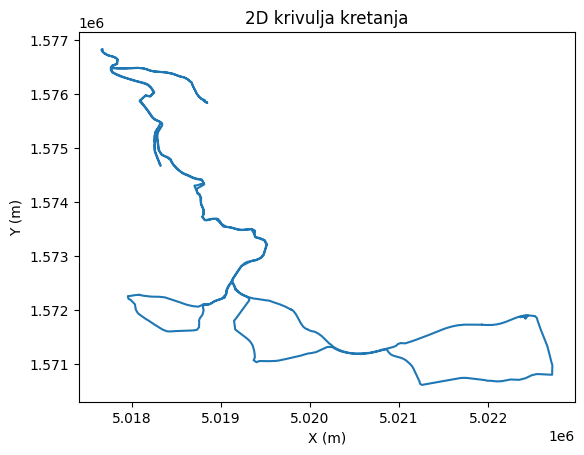

In [63]:
plt.plot(
    df['X'],
    df['Y']
)
plt.title('2D krivulja kretanja')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

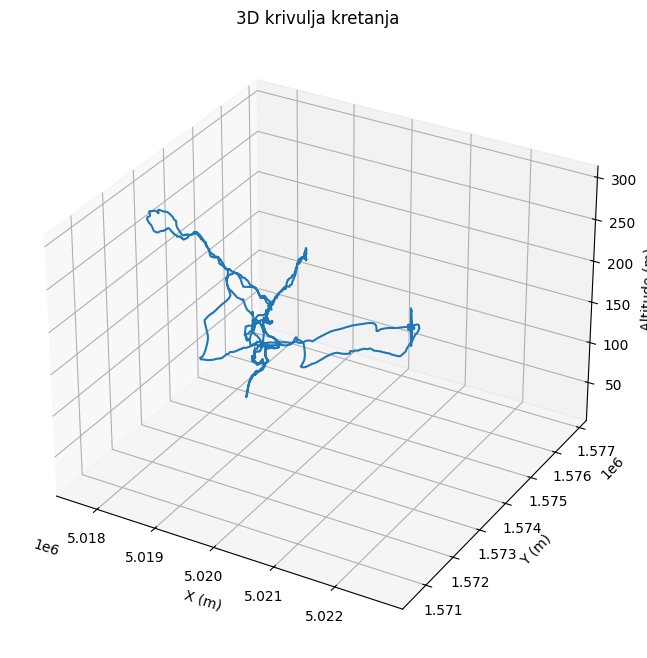

In [64]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(
    df['X'], 
    df['Y'], 
    savgol_filter(df['Altitude'], 100, 3)
)
ax.set_title('3D krivulja kretanja')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Altitude (m)')

plt.show()

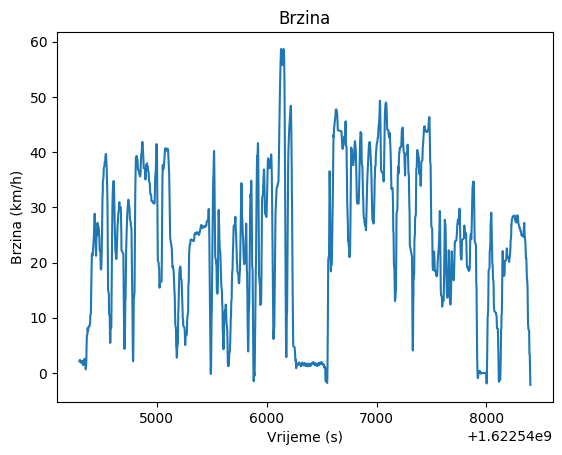

In [65]:
plt.plot(
    df['DateTime'].dt.timestamp() / 1e6,
    savgol_filter(df['Velocity'], 100, 3),
)
plt.title('Brzina')
plt.xlabel('Vrijeme (s)')
plt.ylabel('Brzina (km/h)')
plt.show()

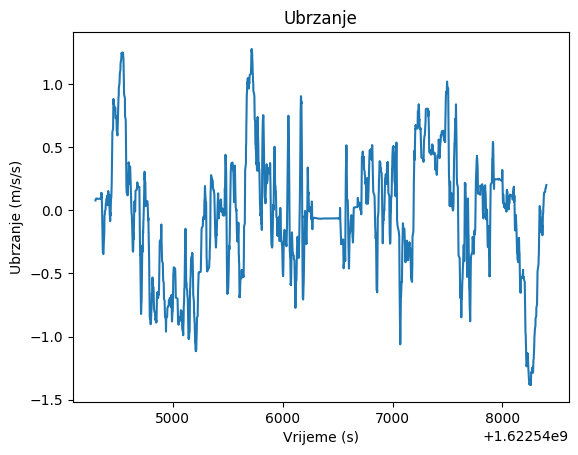

In [66]:
plt.plot(
    df['DateTime'].dt.timestamp() / 1e6,
    savgol_filter(df['AccelerationY'] * 9.81, 100, 3),
)
plt.title('Ubrzanje')
plt.xlabel('Vrijeme (s)')
plt.ylabel('Ubrzanje (m/s/s)')
plt.show()

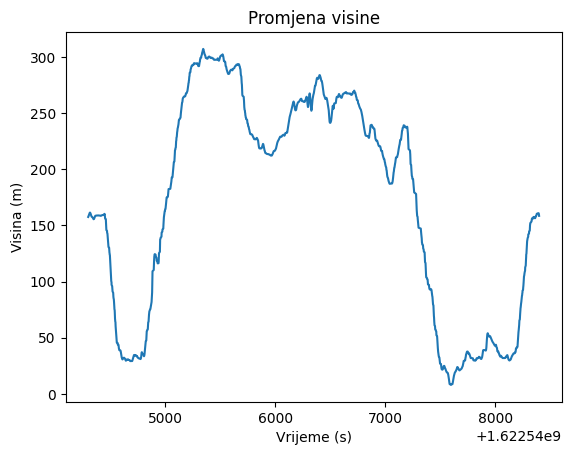

In [67]:
plt.plot(
    df['DateTime'].dt.timestamp() / 1e6,
    savgol_filter(df['Altitude'], 100, 3),
)
plt.title('Promjena visine')
plt.xlabel('Vrijeme (s)')
plt.ylabel('Visina (m)')
plt.show()

In [68]:
def to_first_quadrant_rad(x: float) -> float:
    a = np.abs(x)
    a = a - (a // (np.pi / 2)) * (np.pi / 2)
    return a

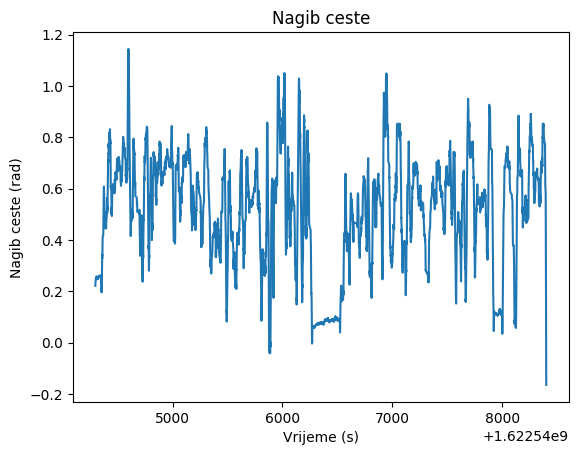

In [69]:
plt.plot(
    df['DateTime'].dt.timestamp() / 1e6,
    savgol_filter(df['GyroscopeZ'].map_elements(to_first_quadrant_rad) , 100, 3),
)
plt.title('Nagib ceste')
plt.xlabel('Vrijeme (s)')
plt.ylabel('Nagib ceste (rad)')
plt.show()

In [70]:
# Harvesinova formula
def ds(
        x: Point,
        y: Point
) -> float:
    return 2 * 6378000 * np.arcsin(
        np.sqrt(
            np.power((y.longitude - x.longitude) / 2, 2)
            + np.cos(x.longitude) * np.power((y.latitude - x.latitude) / 2, 2)
        )
    )

In [71]:
f = Point(*next(zip(df['Latitude'].map_elements(np.deg2rad), df['Longitude'].map_elements(np.deg2rad))))
points = [f] + [Point(*i) for i in zip(df['Latitude'].map_elements(np.deg2rad), df['Longitude'].map_elements(np.deg2rad))]
delta_moved = (ds(*i) for i in pairwise(points))
moved = list(accumulate(delta_moved, lambda x, y: x + y))

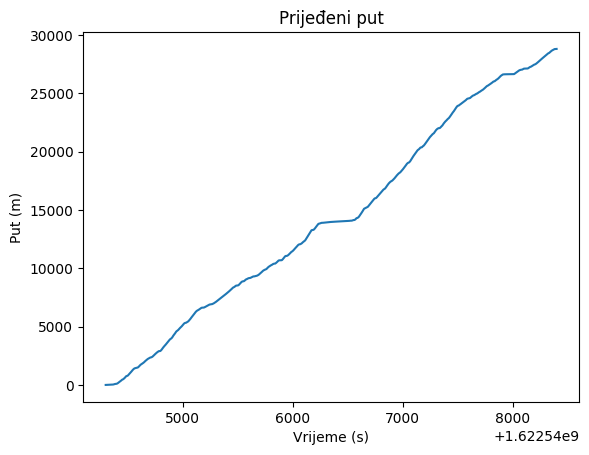

In [72]:
plt.plot(
    df['DateTime'].dt.timestamp() / 1e6,
    moved
)
plt.title('Prijeđeni put')
plt.xlabel('Vrijeme (s)')
plt.ylabel('Put (m)')

plt.show()

In [73]:
df.describe()

describe,AccelerationX,AccelerationY,AccelerationZ,GyroscopeX,GyroscopeY,GyroscopeZ,Latitude,Longitude,Velocity,Altitude,Position,Hours,Minutes,Seconds,Date,DateTime,Y,X
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64
"""count""",9776.0,9776.0,9776.0,9776.0,9776.0,9776.0,9776.0,9776.0,9776.0,9776.0,9776.0,9776.0,9776.0,9776.0,"""9776""","""9776""",9776.0,9776.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0
"""mean""",-0.050049,-0.004825,1.003017,-0.440136,-0.004038,0.052931,14.134695,45.092696,22.580305,174.023895,166.196277,10.795417,30.825389,29.988892,null,null,1.5734e6,5.0196e6
"""std""",0.037009,0.058152,0.010231,0.53678,0.558823,1.41705,0.018312,0.014516,15.827058,97.517645,122.956226,0.403417,16.867793,17.085084,null,null,2038.45233,1615.866881
"""min""",-0.17733,-0.17736,0.97196,-2.08956,-1.66491,-4.23632,14.109408,45.075358,0.0,6.4,0.0,10.0,0.0,0.001,"""06/01/2021""","""2021-06-01 10:…",1.5706e6,5.0177e6
"""25%""",-0.07448,-0.03706,0.99773,-0.68926,-0.24799,-0.39591,14.12051,45.080807,2.5928,51.2,45.0,11.0,16.0,15.492,null,null,1.5719e6,5.0183e6
"""50%""",-0.0427,-0.00652,1.00438,-0.45114,0.00122,-0.06167,14.12425,45.086985,25.5576,215.1,155.0,11.0,31.0,30.063,null,null,1.5723e6,5.0190e6
"""75%""",-0.03152,0.0284,1.00763,-0.20376,0.24188,0.49669,14.155648,45.103833,35.7436,258.1,292.2,11.0,46.0,44.462,null,null,1.5758e6,5.0208e6
"""max""",0.06896,0.17369,1.03259,1.21343,1.66778,4.25036,14.165298,45.120837,59.6344,308.8,360.0,11.0,59.0,59.994,"""06/01/2021""","""2021-06-01 11:…",1.5768e6,5.0227e6


# B

In [114]:
r_earth = 6378000
g = 9.81
air_density = 1.2250
h_vehicle = 1.75
w_vehicle = 2
passenger_count = 5
m_vehicle = 2286
air_resistance_coefficient = 0.32
rolling_resistance_coefficient = 0.0133
tire_width = 0.315
tire_thickness = 0.3 * tire_width
wheel_radius = (22 * 2.53) / 2 / 100 + tire_thickness
transmission_radio = 9.2
power_draw_constant = 370
power_draw_often = 2438
power_draw_intermittent = 1486
power_draw = 370 + 0.6 * 2438 + 0.1 * 1486
battery_voltage = 551

In [75]:
area_vehicle = h_vehicle * w_vehicle

# C
![Alt text](vehicle.png "a title")

In [76]:
f_a = df['AccelerationY'] * g * m_vehicle * -1
f_z = area_vehicle * (df['Velocity'] / 3.6) ** 2 * air_density * air_resistance_coefficient / 2
f_k = df['AccelerationZ'] * g * m_vehicle * rolling_resistance_coefficient

f = f_a - f_z - f_k

f_df = pl.DataFrame([
    f_a.alias('f_a'),
    f_z.alias('f_z'),
    f_k.alias('f_k'),
    f.alias('f')
])
f_df.describe()

describe,f_a,f_z,f_k,f
str,f64,f64,f64,f64
"""count""",9776.0,9776.0,9776.0,9776.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",108.203167,40.246409,299.161135,-231.204377
"""std""",1304.093637,38.85141,3.051616,1306.52905
"""min""",-3895.112885,0.0,289.898032,-4236.798241
"""25%""",-636.888744,0.355842,297.584225,-973.533845
"""50%""",146.215303,34.574766,299.567662,-154.408851
"""75%""",831.09496,67.626311,300.537012,478.256518
"""max""",3977.415058,188.240394,307.981613,3648.567624


In [77]:
def plot_dataframe(
        x: pl.DataFrame,
        title: str,
        x_label: str,
        y_label: str
) -> None:
    for i in x:
        plt.plot(
            df['DateTime'].dt.timestamp() / 1e6,
            i,
            label=i.name,
            alpha=0.5
        )
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()    

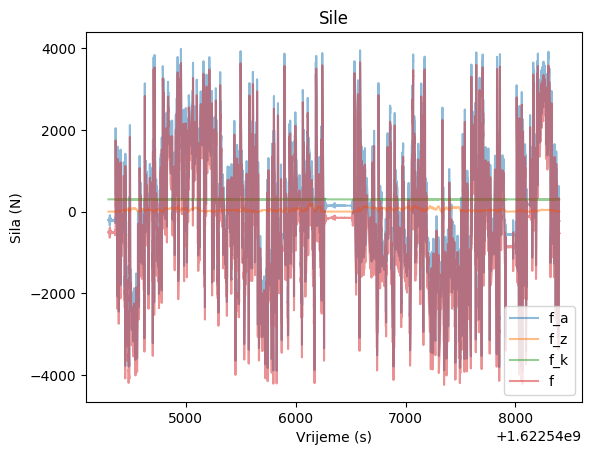

In [78]:
plot_dataframe(
    f_df,
    'Sile',
    'Vrijeme (s)',
    'Sila (N)'
)

# D

In [79]:
p_df = f_df.select(*(i.alias(i.name.replace('f', 'p')) for i in f_df if i.name != 'f')) * df['Velocity'] / 3.6
p_df = p_df.with_columns((p_df['p_a'] + p_df['p_z'] + p_df['p_k']).alias('p'))
p_df.describe()

describe,p_a,p_z,p_k,p
str,f64,f64,f64,f64
"""count""",9776.0,9776.0,9776.0,9776.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",516.75318,414.467539,1876.065364,2807.286083
"""std""",10284.685553,520.405078,1315.56626,10458.743532
"""min""",-47349.443215,0.0,0.0,-41737.887992
"""25%""",-4092.952681,0.256285,216.047435,-1485.0432
"""50%""",58.491354,245.45779,2122.481816,252.956319
"""75%""",5408.477454,671.446613,2962.317587,8141.98921
"""max""",44103.738373,3118.223036,5060.441445,48529.830356


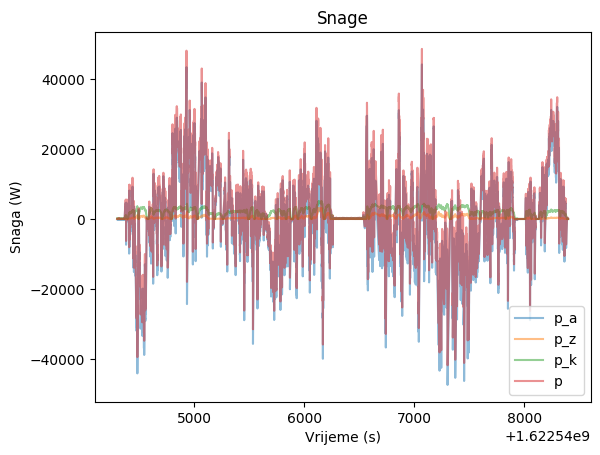

In [80]:
plot_dataframe(
    p_df,
    'Snage',
    'Vrijeme (s)',
    'Snaga (W)'
)

# E

In [81]:
p_abs_df = p_df.select(*(i.abs() for i in p_df))
p_abs_df

p_a,p_z,p_k,p
f64,f64,f64,f64
125.427613,0.161392,185.104341,59.83812
130.965256,0.161392,185.133802,54.329938
142.178983,0.205196,200.657364,58.683577
155.215518,0.256285,216.023806,61.064573
152.792799,0.256285,216.051731,63.515218
149.885537,0.256285,216.040991,66.411739
152.146741,0.256285,216.092546,64.202091
141.325263,0.256285,216.045287,74.976309
146.078407,0.205196,200.699253,54.826042


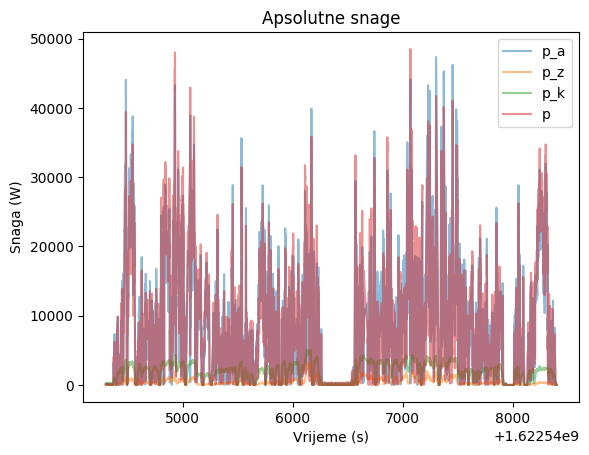

In [82]:
plot_dataframe(
    p_abs_df,
    'Apsolutne snage',
    'Vrijeme (s)',
    'Snaga (W)'
)

In [83]:
p_regen_df = p_df - p_abs_df
p_regen_df

p_a,p_z,p_k,p
f64,f64,f64,f64
-250.855227,0.0,0.0,0.0
-261.930513,0.0,0.0,0.0
-284.357967,0.0,0.0,0.0
-310.431036,0.0,0.0,0.0
-305.585598,0.0,0.0,0.0
-299.771073,0.0,0.0,0.0
-304.293482,0.0,0.0,0.0
-282.650527,0.0,0.0,0.0
-292.156814,0.0,0.0,0.0


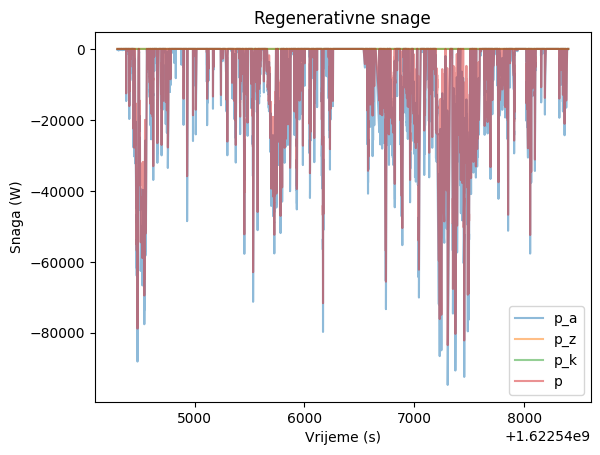

In [84]:
plot_dataframe(
    p_regen_df,
    'Regenerativne snage',
    'Vrijeme (s)',
    'Snaga (W)'
)

# F

In [85]:
delta_t = pl.Series('delta_t', [0] + [j - i for i, j in pairwise(df['DateTime'].dt.timestamp() / 1e6)])
e_df = p_df.select(*(i.alias(i.name.replace('p', 'e')) for i in p_df)) * delta_t
e_df = e_df.with_columns(
    p_abs_df['p'].alias('e_abs') * delta_t,
    p_regen_df['p'].abs().alias('e_regen') * delta_t,
)
e_df = e_df.with_row_count(
    'index'
).with_columns(
    pl.col('index').cast(pl.Int64)
).rolling(
    'index',
    period=f'{e_df.height}i'
).agg(
    pl.sum(*(i for i in e_df.columns))
).select(*(i for i in e_df.columns))
e_df.describe()

describe,e_a,e_z,e_k,e,e_abs,e_regen
str,f64,f64,f64,f64,f64,f64
"""count""",9776.0,9776.0,9776.0,9776.0,9776.0,9776.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.5759e6,789315.717893,3.9534e6,6.3186e6,1.8002e7,1.1684e7
"""std""",2.0992e6,528533.332128,2.3441e6,3.3057e6,9.6363e6,7.1102e6
"""min""",-2.4799e6,0.0,0.0,-1.9022e6,0.0,0.0
"""25%""",-795646.262964,380748.85302,2.2792e6,5.9182e6,1.2422e7,5.7249e6
"""50%""",2.5803e6,732464.143333,3.8511e6,7.5995e6,1.8289e7,1.0260e7
"""75%""",3.4450e6,1.3209e6,6.0400e6,8.1365e6,2.6147e7,1.6971e7
"""max""",4.2387e6,1.6376e6,7.9961e6,1.1334e7,3.5225e7,2.3908e7


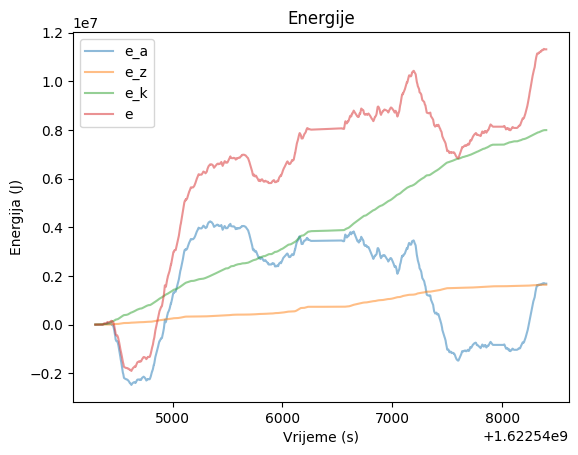

In [86]:
plot_dataframe(
    e_df.select('e_a', 'e_z', 'e_k', 'e'),
    'Energije',
    'Vrijeme (s)',
    'Energija (J)'
)

# G

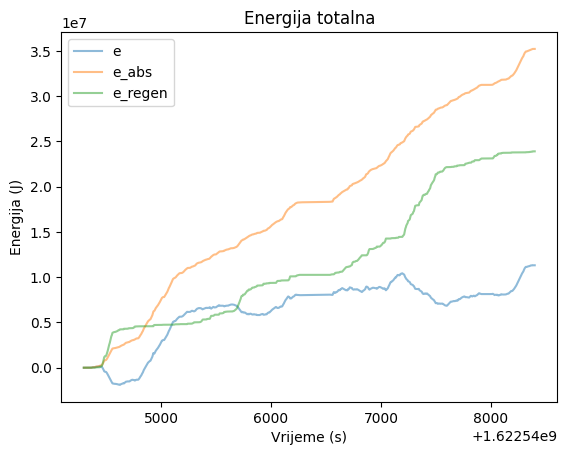

In [87]:
plot_dataframe(
    e_df.select('e', 'e_abs', 'e_regen'),
    'Energija totalna',
    'Vrijeme (s)',
    'Energija (J)'
)

# H

In [88]:
efficiency_battery_wheel = 0.61
efficiency_wheel_battery = 0.56

In [89]:
battery_e_df = e_df.select(
    (e_df['e'] / efficiency_battery_wheel).alias('e_out'),
    (e_df['e_regen'] * efficiency_wheel_battery).alias('e_in'),
)
battery_e_df = battery_e_df.with_columns((battery_e_df['e_out'].abs() - battery_e_df['e_in']).alias('e_total'))
battery_e_df.describe()

describe,e_out,e_in,e_total
str,f64,f64,f64
"""count""",9776.0,9776.0,9776.0
"""null_count""",0.0,0.0,0.0
"""mean""",1.0358e7,6.5428e6,4.1977e6
"""std""",5.4191e6,3.9817e6,3.4035e6
"""min""",-3.1183e6,0.0,-2.5612e6
"""25%""",9.7020e6,3.2059e6,357062.111733
"""50%""",1.2458e7,5.7457e6,5.1647e6
"""75%""",1.3339e7,9.5036e6,7.4284e6
"""max""",1.8580e7,1.3388e7,9.0084e6


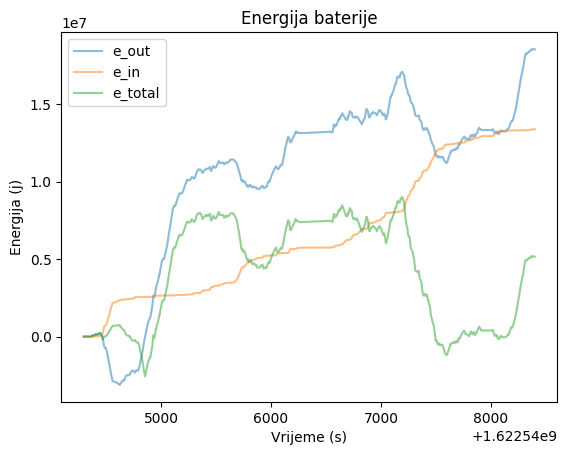

In [90]:
plot_dataframe(
    battery_e_df,
    'Energija baterije',
    'Vrijeme (s)',
    'Energija (j)'
)

# I

In [91]:
power_draw

1981.3999999999999

# J

In [112]:
# J/m
e_avg_draw = sum(
    ((j[0] - i[0]) / (j[1] - i[1]) if (j[1] - i[1]) else 0 for i, j in pairwise(zip(battery_e_df['e_out'], moved)))
) / len(moved) + power_draw * (max(df['DateTime'].dt.timestamp() / 1e6) - min(df['DateTime'].dt.timestamp() / 1e6)) / max(moved)

e_avg_regen = sum(
    ((j[0] - i[0]) / (j[1] - i[1]) if (j[1] - i[1]) else 0 for i, j in pairwise(zip(battery_e_df['e_in'], moved)))
) / len(moved)
e_total = e_avg_draw * 250000 - e_avg_regen * 250000 # J
e_avg_draw, e_avg_regen, e_total

(811.2769082982816, 330.46294400546446, 120203491.07320426)

# K

In [113]:
import math

n_series = math.ceil(battery_voltage / 3.6)
charge_voltage = n_series * 4.2
cut_off_voltage = n_series * 2.5

bv = n_series * 3.6

series_energy = 5 * bv * n_series

n_parallel = math.ceil(e_total / series_energy)

battery_energy = 5 * n_parallel * n_series * bv # J

charge_current = 5 * n_parallel * 0.5
charge_current_max = 5 * n_parallel

discharge_current = 5 * n_parallel * 0.2
discharge_current_max = 5 * n_parallel * 3

n_series, n_parallel, bv, charge_voltage, cut_off_voltage, battery_energy, charge_current, charge_current_max, discharge_current, discharge_current_max

(154,
 282,
 554.4,
 646.8000000000001,
 385.0,
 120382416.0,
 705.0,
 1410,
 282.0,
 4230)

# L

In [121]:
wheel_momentum = max(f_df['f'] * wheel_radius) / 2 # Nm
motor_momentum = 2 * wheel_momentum / 0.95 / transmission_radio

wheel_speed = wheel_momentum * 2 * np.pi / 60 # rad/s
motor_speed = wheel_speed * transmission_radio # rad/s

wheel_momentum, wheel_speed, motor_momentum, motor_speed

(680.0930050682938, 71.21917294934525, 155.627689946978, 655.2163911339762)